# CNN Models #

In [79]:
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(123)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Create Datasets for Modeling ##

In [69]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator(1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train, scale and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [133]:
X_test = test_images.copy()

In [118]:
# reshape labels
y_model = train_labels.T[[1]]
y_test = test_labels.T[[1]]
y_model = y_model.T
y_test = y_test.T
print(y_model.shape)
print(y_test.shape)

(5232, 1)
(624, 1)


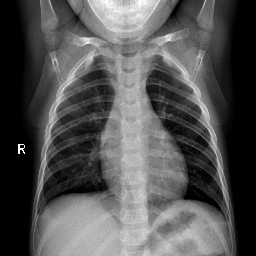

In [86]:
array_to_img(train_images[500])

In [87]:
y_model[500]

array([0.], dtype=float32)

### Split Training Data into Validation Set ###

In [90]:
X_train, X_val, y_train, y_val = train_test_split(train_images, y_model, test_size=0.20, random_state=765)

In [121]:
# check indices for normal-labeled images to verify we have the same set of images later on
normal_indices = [i for i, x in enumerate(y_train) if x == [0.]]
len(X_train), len(normal_indices)

(4185, 1087)

### Created Augmented Images ###

We are augmenting these images so that we can try to fix the overfitting issue we were running into earlier. We will train models on both the normal images and the augmented images to make sure our model isn't overfitting and is, indeed, able to generalize to unseen data.

In [98]:
# augment images with given specification
idg_aug = ImageDataGenerator(rescale = 1./255,
                             rotation_range=45,
                             brightness_range = [0.8, 1.2])

# pull images from directory
aug_generator = idg_aug.flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# create aug data sets
aug_images, aug_labels = next(aug_generator)

Found 5232 images belonging to 2 classes.


In [120]:
# fix labels
y_aug_model = aug_labels.T[[1]]
y_aug_model = y_aug_model.T
print(y_aug_model.shape)

(5232, 1)


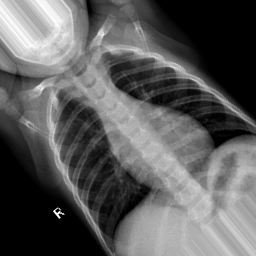

In [119]:
# check to see that augmented image 500 is the same as the orginal image 500
array_to_img(aug_images[500])

In [101]:
y_aug[500]

array([0.], dtype=float32)

### Split Augmented Data the Same Way as Training Data ###

This is so that we can use the same validation set for running models with regular images and augmented images. Only the training images are augmented. The validation set is left the same.

In [108]:
X_aug, _, y_aug, _ = train_test_split(aug_images, y_aug_model, test_size=0.20, random_state=765)

In [122]:
# check indices for verification between normal and augmented sets
aug_indices = [i for i, x in enumerate(y_train) if x == [0.]]
len(X_aug), len(aug_indices)

(4185, 1087)

In [117]:
# check to see that the data was split the same way, meaning that the images in X_aug are the 
# same ones in X_train just transformed
normal_indices == aug_indices

True

## CNN Models ##

In [123]:
# function for visualizing loss, accuracy, and recall across epochs for training and validation set
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

### Model 1, on Normal Training Data ###

In [127]:
# build cnn model
cnn1 = Sequential()
cnn1.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn1.add(layers.MaxPooling2D((2, 2)))
cnn1.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))
cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(32, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

In [137]:
# compile model
cnn1.compile(loss='binary_crossentropy',
             optimizer = "sgd",
             metrics=['accuracy', 'Recall'])

In [130]:
# fit model on training set with normal images and validate on validation set
history_1 = cnn1.fit(X_train, y_train,
                     epochs=10,
                     batch_size=50,
                     validation_data=(X_val, y_val),
                     workers = -1)

Epoch 1/10
84/84 [==============================] - 490s 6s/step - loss: 0.5428 - accuracy: 0.7415 - recall: 0.9874 - val_loss: 0.4360 - val_accuracy: 0.7775 - val_recall: 0.9987
Epoch 2/10
84/84 [==============================] - 414s 5s/step - loss: 0.4356 - accuracy: 0.8131 - recall: 0.9526 - val_loss: 0.3591 - val_accuracy: 0.8071 - val_recall: 0.9987
Epoch 3/10
84/84 [==============================] - 429s 5s/step - loss: 0.3399 - accuracy: 0.8597 - recall: 0.9312 - val_loss: 0.2696 - val_accuracy: 0.8816 - val_recall: 0.9911
Epoch 4/10
84/84 [==============================] - 477s 6s/step - loss: 0.2516 - accuracy: 0.8963 - recall: 0.9484 - val_loss: 0.3034 - val_accuracy: 0.8749 - val_recall: 0.8420
Epoch 5/10
84/84 [==============================] - 498s 6s/step - loss: 0.2158 - accuracy: 0.9211 - recall: 0.9548 - val_loss: 0.1727 - val_accuracy: 0.9303 - val_recall: 0.9771
Epoch 6/10
84/84 [==============================] - 457s 5s/step - loss: 0.1831 - accuracy: 0.9274 - reca

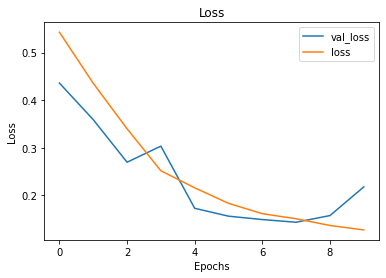

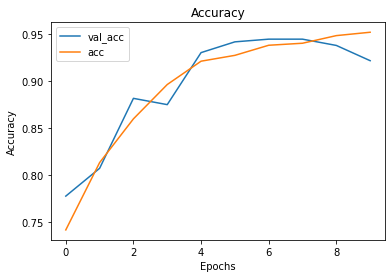

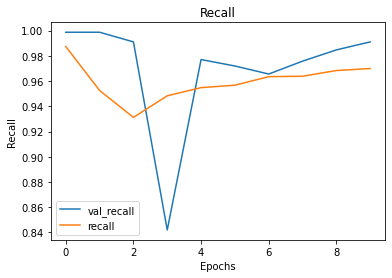

In [131]:
visualize_training_results(history_1)

In [134]:
# evaluate training and test sets
results_train = cnn1.evaluate(X_train, y_train)
results_test = cnn1.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 13s 661ms/step - loss: 449.9419 - accuracy: 0.6667 - recall: 1.0000
[0.1724957823753357, 0.928554356098175, 0.9919303059577942] [449.94189453125, 0.6666666865348816, 1.0]


Very poor performance on the test set. It is only slightly better than our baseline model.

### Model 1, on Augmented Training Data ###

In [171]:
# build cnn model
cnn1_aug = Sequential()
cnn1_aug.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn1_aug.add(layers.MaxPooling2D((2, 2)))
cnn1_aug.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn1_aug.add(layers.MaxPooling2D((2, 2)))
cnn1_aug.add(layers.Flatten())
cnn1_aug.add(layers.Dense(32, activation='relu'))
cnn1_aug.add(layers.Dense(1, activation='sigmoid'))

In [172]:
# compile model
cnn1_aug.compile(loss='binary_crossentropy',
                 optimizer = "sgd",
                 metrics=['accuracy', 'Recall'])

In [173]:
history_1_aug = cnn1_aug.fit(X_aug, y_aug,
                             epochs=10,
                             batch_size=50,
                             validation_data=(X_val, y_val),
                             workers = -1,
                             class_weight={0:2.85, 1:1})

Epoch 1/10
84/84 [==============================] - 412s 5s/step - loss: 1.0016 - accuracy: 0.5553 - recall: 0.5394 - val_loss: 0.5175 - val_accuracy: 0.7526 - val_recall: 1.0000
Epoch 2/10
84/84 [==============================] - 404s 5s/step - loss: 0.8600 - accuracy: 0.7441 - recall: 0.7531 - val_loss: 0.5190 - val_accuracy: 0.8835 - val_recall: 0.8841
Epoch 3/10
84/84 [==============================] - 415s 5s/step - loss: 0.6443 - accuracy: 0.8050 - recall: 0.7912 - val_loss: 0.2658 - val_accuracy: 0.9035 - val_recall: 0.9643
Epoch 4/10
84/84 [==============================] - 414s 5s/step - loss: 0.5160 - accuracy: 0.8406 - recall: 0.8292 - val_loss: 0.4905 - val_accuracy: 0.7717 - val_recall: 0.7019
Epoch 5/10
84/84 [==============================] - 414s 5s/step - loss: 0.4470 - accuracy: 0.8743 - recall: 0.8638 - val_loss: 0.2387 - val_accuracy: 0.9074 - val_recall: 0.9223
Epoch 6/10
84/84 [==============================] - 414s 5s/step - loss: 0.4070 - accuracy: 0.8848 - reca

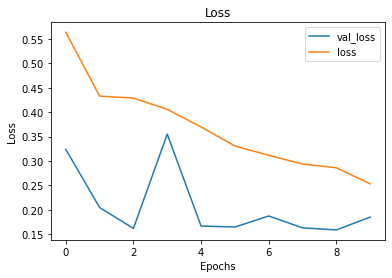

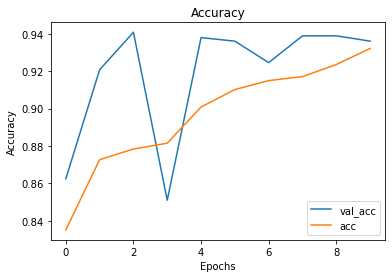

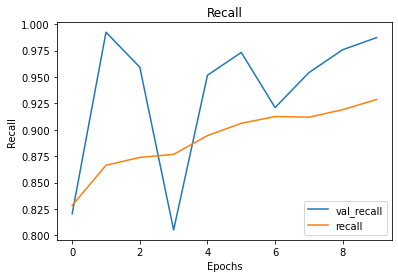

In [146]:
visualize_training_results(history_1_aug)

In [148]:
# evaluate training and test sets
results_train = cnn1_aug.evaluate(X_aug, y_aug)
results_test = cnn1_aug.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 14s 685ms/step - loss: 443.2849 - accuracy: 0.6715 - recall: 1.0000
[0.142299622297287, 0.9416965246200562, 0.9816010594367981] [443.28485107421875, 0.6714743375778198, 1.0]


This model gave a better accuracy when the model was trained on the augmented data. A good indiction that we can use the augmented data to get the neural network to learn the patterns in the images and not just the images themselves. Still overfit, we can try to regularize the model.

### Model 2 with L1 regularization, on Normal Training Data ###

In [174]:
# build cnn model with L1 regularization
cnn2 = Sequential()
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l1', input_shape=(256, 256,  3)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l1'))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(32, activation='relu', kernel_regularizer='l1' ))
cnn2.add(layers.Dense(1, activation='sigmoid'))

In [175]:
# compile model
cnn2.compile(loss='binary_crossentropy',
             optimizer = "sgd",
             metrics=['accuracy', 'Recall'])

In [176]:
history_2 = cnn2.fit(X_train, y_train,
                     epochs=10,
                     batch_size=50,
                     validation_data=(X_val, y_val),
                     workers = -1,
                     class_weight={0:2.85, 1:1})

Epoch 1/10
84/84 [==============================] - 457s 5s/step - loss: 48.9685 - accuracy: 0.4987 - recall: 0.4354 - val_loss: 9.6004 - val_accuracy: 0.7498 - val_recall: 1.0000
Epoch 2/10
84/84 [==============================] - 414s 5s/step - loss: 9.1951 - accuracy: 0.5603 - recall: 0.6152 - val_loss: 8.1345 - val_accuracy: 0.7498 - val_recall: 1.0000
Epoch 3/10
84/84 [==============================] - 412s 5s/step - loss: 7.8371 - accuracy: 0.6136 - recall: 0.7485 - val_loss: 6.8662 - val_accuracy: 0.7498 - val_recall: 1.0000
Epoch 4/10
84/84 [==============================] - 426s 5s/step - loss: 6.6469 - accuracy: 0.6949 - recall: 0.8980 - val_loss: 5.7679 - val_accuracy: 0.7498 - val_recall: 1.0000
Epoch 5/10
84/84 [==============================] - 415s 5s/step - loss: 5.6244 - accuracy: 0.6980 - recall: 0.9061 - val_loss: 4.8283 - val_accuracy: 0.7498 - val_recall: 1.0000
Epoch 6/10
84/84 [==============================] - 420s 5s/step - loss: 4.7717 - accuracy: 0.7395 - rec

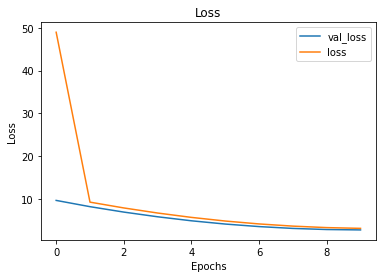

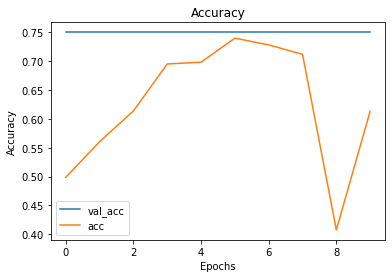

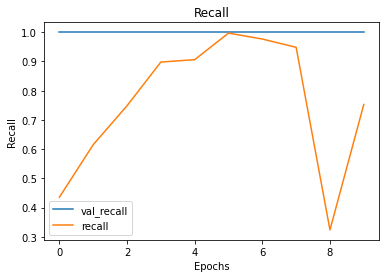

In [186]:
visualize_training_results(history_2)

In [187]:
# evaluate training and test sets
results_train = cnn2.evaluate(X_aug, y_aug)
results_test = cnn2.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 15s 725ms/step - loss: 2.6932 - accuracy: 0.6250 - recall: 1.0000
[2.692859172821045, 0.7402628660202026, 1.0] [2.6932148933410645, 0.625, 1.0]


The model performed as well as our baseline even after it was regularized. This show us that the model is not good and we need to construct a better one.

### Model 2 with L1 regularization, on Augmented Training Data ###

In [177]:
# build cnn model with L1 regularization
cnn2_aug = Sequential()
cnn2_aug.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l1', input_shape=(256, 256,  3)))
cnn2_aug.add(layers.MaxPooling2D((2, 2)))
cnn2_aug.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l1'))
cnn2_aug.add(layers.MaxPooling2D((2, 2)))
cnn2_aug.add(layers.Flatten())
cnn2_aug.add(layers.Dense(32, activation='relu', kernel_regularizer='l1' ))
cnn2_aug.add(layers.Dense(1, activation='sigmoid'))

In [178]:
# compile model
cnn2_aug.compile(loss='binary_crossentropy',
                 optimizer = "sgd",
                 metrics=['accuracy', 'Recall'])

In [179]:
history_2_aug = cnn2_aug.fit(X_aug, y_aug,
                             epochs=10,
                             batch_size=50,
                             validation_data=(X_val, y_val),
                             workers = -1,
                             class_weight={0:2.85, 1:1})

Epoch 1/10
84/84 [==============================] - 437s 5s/step - loss: 48.9816 - accuracy: 0.5283 - recall: 0.5455 - val_loss: 9.6239 - val_accuracy: 0.7001 - val_recall: 0.9185
Epoch 2/10
84/84 [==============================] - 412s 5s/step - loss: 9.2301 - accuracy: 0.4703 - recall: 0.4364 - val_loss: 8.1793 - val_accuracy: 0.6485 - val_recall: 0.8115
Epoch 3/10
84/84 [==============================] - 420s 5s/step - loss: 7.8678 - accuracy: 0.4839 - recall: 0.4700 - val_loss: 6.9023 - val_accuracy: 0.7498 - val_recall: 1.0000
Epoch 4/10
84/84 [==============================] - 423s 5s/step - loss: 6.6727 - accuracy: 0.5735 - recall: 0.6507 - val_loss: 5.7942 - val_accuracy: 0.2502 - val_recall: 0.0000e+00
Epoch 5/10
84/84 [==============================] - 415s 5s/step - loss: 5.6487 - accuracy: 0.3809 - recall: 0.2576 - val_loss: 4.8561 - val_accuracy: 0.7498 - val_recall: 1.0000
Epoch 6/10
84/84 [==============================] - 424s 5s/step - loss: 4.7944 - accuracy: 0.5395 -

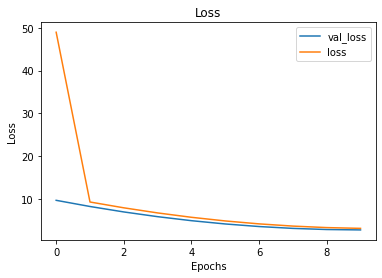

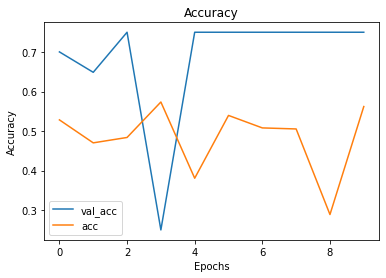

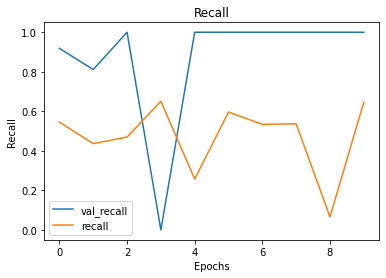

In [188]:
visualize_training_results(history_2_aug)

In [189]:
# evaluate training and test sets
results_train = cnn2_aug.evaluate(X_aug, y_aug)
results_test = cnn2_aug.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 10s 498ms/step - loss: 2.6938 - accuracy: 0.6250 - recall: 1.0000
[2.6935513019561768, 0.7402628660202026, 1.0] [2.693763494491577, 0.625, 1.0]


This model gave the exact same results as our baseline on our test set. Not good. A new model is needed.

### Model 3 with Dropout and AdaGrad Optimizer, on Normal Training Data

In [182]:
# build cnn model with dropout
cnn3 = Sequential()
cnn3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn3.add(layers.MaxPooling2D((2, 2)))
cnn3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn3.add(layers.MaxPooling2D((2, 2)))
cnn3.add(layers.Dropout(0.2))
cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(32, activation='relu', kernel_regularizer='l1' ))
cnn3.add(layers.Dropout(0.5))
cnn3.add(layers.Dense(1, activation='sigmoid'))

In [183]:
# compile model
from keras.optimizers import Adagrad

cnn3.compile(loss='binary_crossentropy',
             optimizer = Adagrad(),
             metrics=['accuracy', 'Recall'])

In [190]:
history_3 = cnn3.fit(X_train, y_train,
                     epochs=10,
                     batch_size=50,
                     validation_data=(X_val, y_val),
                     workers = -1,
                     class_weight={0:2.85, 1:1})

Epoch 1/10
84/84 [==============================] - 385s 5s/step - loss: 1.5704 - accuracy: 0.5876 - recall: 0.5759 - val_loss: 1.2431 - val_accuracy: 0.6294 - val_recall: 0.5108
Epoch 2/10
84/84 [==============================] - 378s 4s/step - loss: 1.5310 - accuracy: 0.6055 - recall: 0.5762 - val_loss: 1.2081 - val_accuracy: 0.8443 - val_recall: 0.8293
Epoch 3/10
84/84 [==============================] - 383s 5s/step - loss: 1.5213 - accuracy: 0.6349 - recall: 0.6175 - val_loss: 1.1882 - val_accuracy: 0.7765 - val_recall: 1.0000
Epoch 4/10
84/84 [==============================] - 391s 5s/step - loss: 1.4820 - accuracy: 0.6557 - recall: 0.6285 - val_loss: 1.2036 - val_accuracy: 0.7564 - val_recall: 0.6866
Epoch 5/10
84/84 [==============================] - 391s 5s/step - loss: 1.4470 - accuracy: 0.6956 - recall: 0.6762 - val_loss: 1.1215 - val_accuracy: 0.8825 - val_recall: 0.9032
Epoch 6/10
84/84 [==============================] - 380s 5s/step - loss: 1.4015 - accuracy: 0.7164 - reca

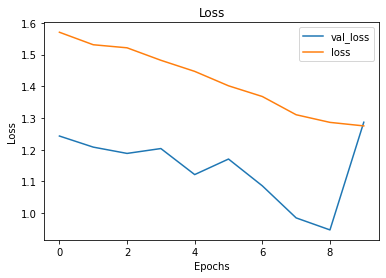

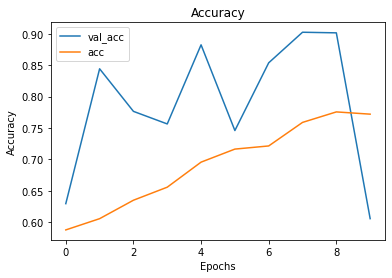

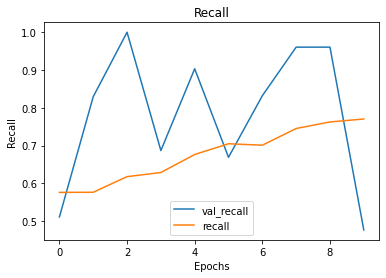

In [191]:
visualize_training_results(history_3)

In [192]:
# evaluate training and test sets
results_train = cnn3.evaluate(X_aug, y_aug)
results_test = cnn3.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 12s 602ms/step - loss: 66.2855 - accuracy: 0.6715 - recall: 0.4846
[1.2088966369628906, 0.6898446679115295, 0.7033569812774658] [66.28553009033203, 0.6714743375778198, 0.48461538553237915]


The results are not good. While the model is not overfit accuracy is not that much better than our baseline and recall is actually worse. Overall performance is actually worse. Adagrad optimization performed worse that SGD.

### Model 3 with Dropout and AdaGrad Optimizer, on Augmented Training Data ###

In [193]:
# build cnn model with dropout
cnn3_aug = Sequential()
cnn3_aug.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn3_aug.add(layers.MaxPooling2D((2, 2)))
cnn3_aug.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn3_aug.add(layers.MaxPooling2D((2, 2)))
cnn3_aug.add(layers.Dropout(0.2))
cnn3_aug.add(layers.Flatten())
cnn3_aug.add(layers.Dense(32, activation='relu', kernel_regularizer='l1' ))
cnn3_aug.add(layers.Dropout(0.5))
cnn3_aug.add(layers.Dense(1, activation='sigmoid'))

In [194]:
cnn3_aug.compile(loss='binary_crossentropy',
                 optimizer = Adagrad(),
                 metrics=['accuracy', 'Recall'])

In [195]:
history_3_aug = cnn3_aug.fit(X_aug, y_aug,
                             epochs=10,
                             batch_size=50,
                             validation_data=(X_val, y_val),
                             workers = -1,
                             class_weight={0:2.85, 1:1})

Epoch 1/10
84/84 [==============================] - 366s 4s/step - loss: 94.1668 - accuracy: 0.5687 - recall: 0.6023 - val_loss: 55.1505 - val_accuracy: 0.3610 - val_recall: 0.1478
Epoch 2/10
84/84 [==============================] - 384s 5s/step - loss: 30.7569 - accuracy: 0.5907 - recall: 0.5868 - val_loss: 11.2163 - val_accuracy: 0.7498 - val_recall: 1.0000
Epoch 3/10
84/84 [==============================] - 371s 4s/step - loss: 4.2940 - accuracy: 0.5551 - recall: 0.5536 - val_loss: 1.3198 - val_accuracy: 0.7498 - val_recall: 1.0000
Epoch 4/10
84/84 [==============================] - 378s 4s/step - loss: 1.6265 - accuracy: 0.5381 - recall: 0.5617 - val_loss: 1.3285 - val_accuracy: 0.2502 - val_recall: 0.0000e+00
Epoch 5/10
84/84 [==============================] - 376s 4s/step - loss: 1.5796 - accuracy: 0.4951 - recall: 0.4948 - val_loss: 1.2225 - val_accuracy: 0.7498 - val_recall: 1.0000
Epoch 6/10
84/84 [==============================] - 385s 5s/step - loss: 1.5532 - accuracy: 0.517

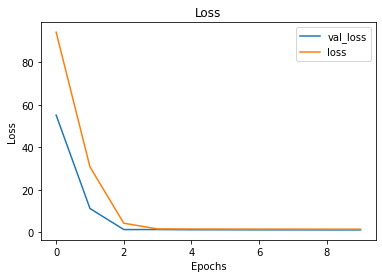

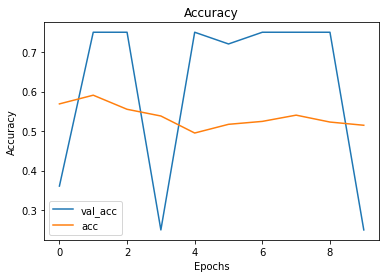

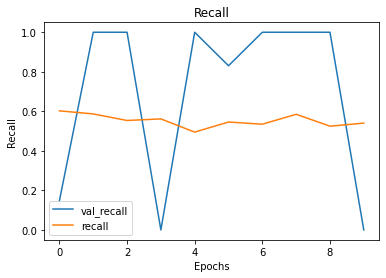

In [196]:
visualize_training_results(history_3_aug)

In [197]:
# evaluate training and test sets
results_train = cnn3_aug.evaluate(X_aug, y_aug)
results_test = cnn3_aug.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 11s 546ms/step - loss: 2.6800 - accuracy: 0.3750 - recall: 0.0000e+00
[1.1522828340530396, 0.25973716378211975, 0.0] [2.6800084114074707, 0.375, 0.0]


Drop out and Adagrad optimizer performed terribly, worse than our baseline!

## Trying Wayne's Best Model, on Normal Training Data ##

Wayne created a very strong model. I will try to replicate/verify the strength of the model below.

In [203]:
!pip install tensorflow_addons

     |████████████████████████████████| 613 kB 3.2 MB/s eta 0:00:01


In [205]:
# 4th model using Wayne's Best -- verifying results
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping

cnn_4 = Sequential()
cnn_4.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Flatten())
cnn_4.add(layers.Dense(32, activation='relu'))
cnn_4.add(layers.Dense(1, activation='sigmoid'))

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
        [1407*20, 1407*30], [1e-3, 1e-4, 1e-5])
wd = lambda: 1e-1 * schedule(step)


cnn_4.compile(loss='binary_crossentropy',
              optimizer = tfa.optimizers.AdamW(learning_rate=schedule, weight_decay=wd, amsgrad=True),
              metrics=['accuracy', 'Recall'])

results_4 = cnn_4.fit(X_train, y_train,
                      epochs=30,
                      validation_data=(X_val, y_val),
                      callbacks= [EarlyStopping(patience = 3, restore_best_weights=True)],
                      class_weight = {0: 3, 1: 1},
                      workers = -1)

Epoch 1/30
131/131 [==============================] - 318s 2s/step - loss: 0.5073 - accuracy: 0.8595 - recall: 0.8625 - val_loss: 0.1769 - val_accuracy: 0.9456 - val_recall: 0.9325
Epoch 2/30
131/131 [==============================] - 303s 2s/step - loss: 0.1693 - accuracy: 0.9575 - recall: 0.9558 - val_loss: 0.1326 - val_accuracy: 0.9570 - val_recall: 0.9567
Epoch 3/30
131/131 [==============================] - 255s 2s/step - loss: 0.1218 - accuracy: 0.9713 - recall: 0.9693 - val_loss: 0.1540 - val_accuracy: 0.9503 - val_recall: 0.9401
Epoch 4/30
131/131 [==============================] - 155s 1s/step - loss: 0.0982 - accuracy: 0.9759 - recall: 0.9745 - val_loss: 0.1244 - val_accuracy: 0.9618 - val_recall: 0.9618
Epoch 5/30
131/131 [==============================] - 158s 1s/step - loss: 0.0968 - accuracy: 0.9747 - recall: 0.9716 - val_loss: 0.1068 - val_accuracy: 0.9656 - val_recall: 0.9745
Epoch 6/30
131/131 [==============================] - 157s 1s/step - loss: 0.0756 - accuracy: 0

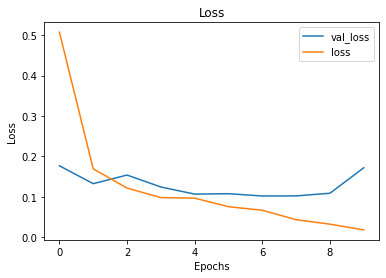

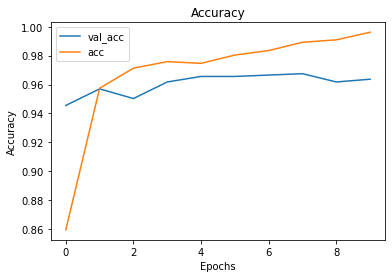

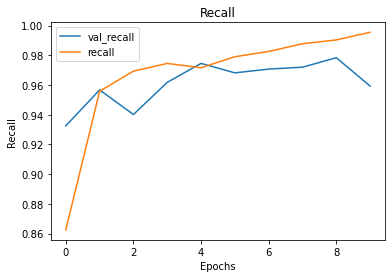

In [206]:
visualize_training_results(results_4)

In [208]:
# evaluate training and test sets
results_train = cnn_4.evaluate(X_train, y_train)
results_test = cnn_4.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 9s 434ms/step - loss: 163.6159 - accuracy: 0.8253 - recall: 0.9667
[0.024972770363092422, 0.9921147227287292, 0.9896707534790039] [163.6159210205078, 0.8253205418586731, 0.9666666388511658]


Best results across all models tried in this notebook. Though it is overfit to the training set, it has given the highest accuracy and recall of all the models tried. Some regularization could help this perform even better.

### Wayne's Best Model, on Augmented Data ###

In [209]:
# 4th model using Wayne's Best -- verifying results
cnn_4 = Sequential()
cnn_4.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_4.add(layers.MaxPooling2D((2, 2)))
cnn_4.add(layers.Flatten())
cnn_4.add(layers.Dense(32, activation='relu'))
cnn_4.add(layers.Dense(1, activation='sigmoid'))

cnn_4.compile(loss='binary_crossentropy',
              optimizer = tfa.optimizers.AdamW(learning_rate=schedule, weight_decay=wd, amsgrad=True),
              metrics=['accuracy', 'Recall'])

results_4 = cnn_4.fit(X_aug, y_aug,
                      epochs=30,
                      validation_data=(X_val, y_val),
                      callbacks= [EarlyStopping(patience = 3, restore_best_weights=True)],
                      class_weight = {0: 3, 1: 1},
                      workers = -1)

Epoch 1/30
131/131 [==============================] - 177s 1s/step - loss: 0.6361 - accuracy: 0.7986 - recall: 0.7811 - val_loss: 0.3922 - val_accuracy: 0.8329 - val_recall: 0.7847
Epoch 2/30
131/131 [==============================] - 170s 1s/step - loss: 0.3755 - accuracy: 0.8994 - recall: 0.8861 - val_loss: 0.1804 - val_accuracy: 0.9226 - val_recall: 0.9720
Epoch 3/30
131/131 [==============================] - 183s 1s/step - loss: 0.2719 - accuracy: 0.9247 - recall: 0.9180 - val_loss: 0.4577 - val_accuracy: 0.8204 - val_recall: 0.7631
Epoch 4/30
131/131 [==============================] - 215s 2s/step - loss: 0.2684 - accuracy: 0.9254 - recall: 0.9174 - val_loss: 0.3577 - val_accuracy: 0.8625 - val_recall: 0.8191
Epoch 5/30
131/131 [==============================] - 194s 1s/step - loss: 0.1977 - accuracy: 0.9477 - recall: 0.9422 - val_loss: 0.1636 - val_accuracy: 0.9303 - val_recall: 0.9414
Epoch 6/30
131/131 [==============================] - 198s 2s/step - loss: 0.1694 - accuracy: 0

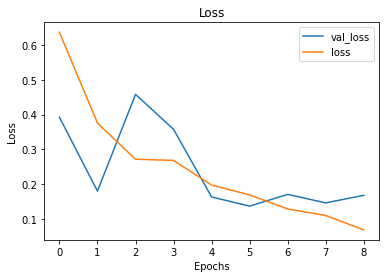

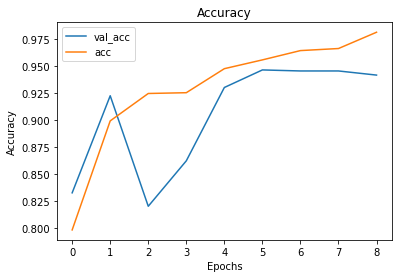

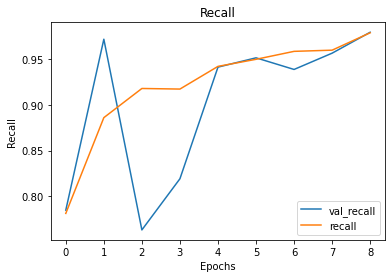

In [210]:
visualize_training_results(results_4)

In [212]:
# evaluate training and test sets
results_train = cnn_4.evaluate(X_aug, y_aug)
results_test = cnn_4.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 10s 478ms/step - loss: 136.4302 - accuracy: 0.7869 - recall: 0.9872
[0.08248718082904816, 0.9710872173309326, 0.9622337222099304] [136.43017578125, 0.7868589758872986, 0.9871794581413269]


Wayne's model performed the best on both the normal and augmented images, it gave the best accuracy and recall for both sets. It is still overfitting though, so maybe we can improve the results by regularizing this model.

### Best Model with L1 Regularization, on Normal Training Set ###

In [215]:
# 4th model using Wayne's Best -- verifying results
from keras.regularizers import l1, l2

cnn5 = Sequential()
cnn5.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same', input_shape=(256, 256, 3)))
cnn5.add(layers.MaxPooling2D((2, 2)))
cnn5.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)))
cnn5.add(layers.MaxPooling2D((2, 2)))
cnn5.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'))
cnn5.add(layers.MaxPooling2D((2, 2)))
cnn5.add(layers.Flatten())
cnn5.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.0005)))
cnn5.add(layers.Dense(1, activation='sigmoid'))

cnn5.compile(loss='binary_crossentropy',
              optimizer = tfa.optimizers.AdamW(learning_rate=schedule, weight_decay=wd, amsgrad=True),
              metrics=['accuracy', 'Recall'])

results5 = cnn5.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks= [EarlyStopping(patience = 3, restore_best_weights=True)],
                    class_weight = {0: 3, 1: 1},
                    workers = -1)

Epoch 1/30
131/131 [==============================] - 164s 1s/step - loss: 0.7435 - accuracy: 0.7384 - recall: 0.6969 - val_loss: 0.2798 - val_accuracy: 0.9207 - val_recall: 0.9083
Epoch 2/30
131/131 [==============================] - 199s 2s/step - loss: 0.2484 - accuracy: 0.9529 - recall: 0.9496 - val_loss: 0.1644 - val_accuracy: 0.9589 - val_recall: 0.9707
Epoch 3/30
131/131 [==============================] - 188s 1s/step - loss: 0.1827 - accuracy: 0.9668 - recall: 0.9668 - val_loss: 0.1858 - val_accuracy: 0.9561 - val_recall: 0.9516
Epoch 4/30
131/131 [==============================] - 166s 1s/step - loss: 0.1745 - accuracy: 0.9701 - recall: 0.9700 - val_loss: 0.1988 - val_accuracy: 0.9513 - val_recall: 0.9427
Epoch 5/30
131/131 [==============================] - 160s 1s/step - loss: 0.1686 - accuracy: 0.9718 - recall: 0.9684 - val_loss: 0.1521 - val_accuracy: 0.9599 - val_recall: 0.9758
Epoch 6/30
131/131 [==============================] - 160s 1s/step - loss: 0.1409 - accuracy: 0

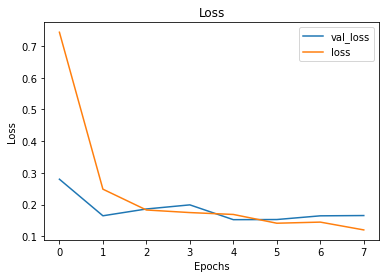

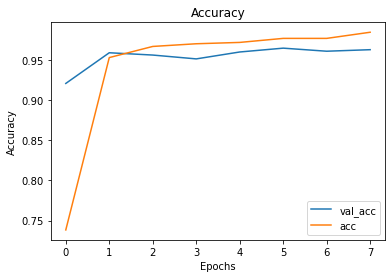

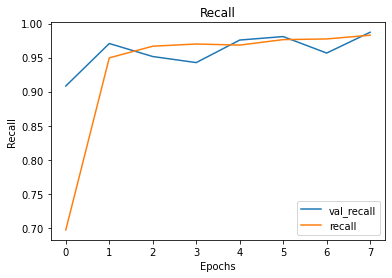

In [217]:
visualize_training_results(results5)

In [221]:
# evaluate training and test sets
results_train = cnn5.evaluate(X_train, y_train)
results_test = cnn5.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 9s 465ms/step - loss: 98.6281 - accuracy: 0.8285 - recall: 0.9872
[0.10248500108718872, 0.9825567603111267, 0.9861201047897339] [98.62812805175781, 0.8285256624221802, 0.9871794581413269]


Best model so far in terms of overfitting and performance. 82.8% accuracy and 98.7% recall is very close to the type of scores we're looking for. It seems that our model is reducing false negatives, but increasing the number of false positives. 

### Best Model with L2 Regularization, on Augmented Set ###

In [219]:
# 4th model using Wayne's Best -- verifying results
from keras.regularizers import l1, l2

cnn5_aug = Sequential()
cnn5_aug.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same', input_shape=(256, 256, 3)))
cnn5_aug.add(layers.MaxPooling2D((2, 2)))
cnn5_aug.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)))
cnn5_aug.add(layers.MaxPooling2D((2, 2)))
cnn5_aug.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), padding='same'))
cnn5_aug.add(layers.MaxPooling2D((2, 2)))
cnn5_aug.add(layers.Flatten())
cnn5_aug.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.0005)))
cnn5_aug.add(layers.Dense(1, activation='sigmoid'))

cnn5_aug.compile(loss='binary_crossentropy',
              optimizer = tfa.optimizers.AdamW(learning_rate=schedule, weight_decay=wd, amsgrad=True),
              metrics=['accuracy', 'Recall'])

results5_aug = cnn5_aug.fit(X_aug, y_aug,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks= [EarlyStopping(patience = 3, restore_best_weights=True)],
                    class_weight = {0: 3, 1: 1},
                    workers = -1)

Epoch 1/30
131/131 [==============================] - 191s 1s/step - loss: 0.7003 - accuracy: 0.8160 - recall: 0.8121 - val_loss: 0.3029 - val_accuracy: 0.9112 - val_recall: 0.9274
Epoch 2/30
131/131 [==============================] - 199s 2s/step - loss: 0.4078 - accuracy: 0.9049 - recall: 0.8954 - val_loss: 0.2980 - val_accuracy: 0.8988 - val_recall: 0.9885
Epoch 3/30
131/131 [==============================] - 179s 1s/step - loss: 0.3122 - accuracy: 0.9362 - recall: 0.9290 - val_loss: 0.2386 - val_accuracy: 0.9284 - val_recall: 0.9210
Epoch 4/30
131/131 [==============================] - 184s 1s/step - loss: 0.3046 - accuracy: 0.9360 - recall: 0.9309 - val_loss: 0.3958 - val_accuracy: 0.8758 - val_recall: 0.8433
Epoch 5/30
131/131 [==============================] - 166s 1s/step - loss: 0.2811 - accuracy: 0.9434 - recall: 0.9371 - val_loss: 0.2339 - val_accuracy: 0.9389 - val_recall: 0.9478
Epoch 6/30
131/131 [==============================] - 194s 1s/step - loss: 0.2565 - accuracy: 0

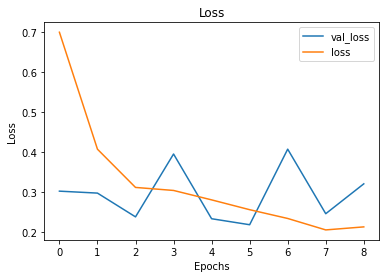

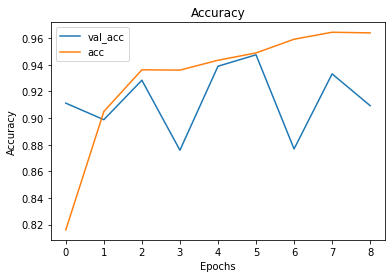

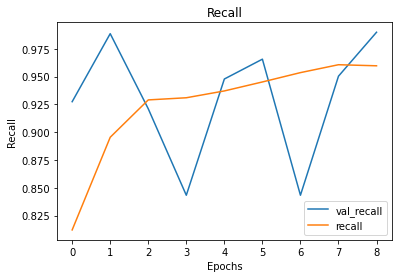

In [220]:
visualize_training_results(results5_aug)

In [222]:
# evaluate training and test sets
results_train = cnn5_aug.evaluate(X_aug, y_aug)
results_test = cnn5_aug.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 21s 1s/step - loss: 110.8026 - accuracy: 0.8237 - recall: 0.9872
[0.14138910174369812, 0.9765830636024475, 0.973854124546051] [110.80257415771484, 0.8237179517745972, 0.9871794581413269]


We can see that training the same model on the augmented images produces the same results as the model trained on the normal images. This model has produced the best results so far. As mentioned above, the accuracy score is 82.4% and the recall is 98.7%. We have done a good job at reducing false negatives while being as accurate in the classification as possible. 

## Analyzing Results ##

Below, we will analyze the results of our best model and see where the model is misclassifying the images.

In [281]:
# getting predictions for test set and mapping them to 0 and 1
predictions = cnn5_aug.predict(X_test)
predictions = np.where(predictions>0.5, 1, 0)

In [272]:
# verify results using sklearn to make sure mappings are correct
from sklearn import metrics

print('accuracy:', metrics.accuracy_score(y_test, predictions))
print('recall:', metrics.recall_score(y_test, predictions))

accuracy: 0.8237179487179487
recall: 0.9871794871794872


In [234]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
cm

array([[129, 105],
       [  5, 385]])

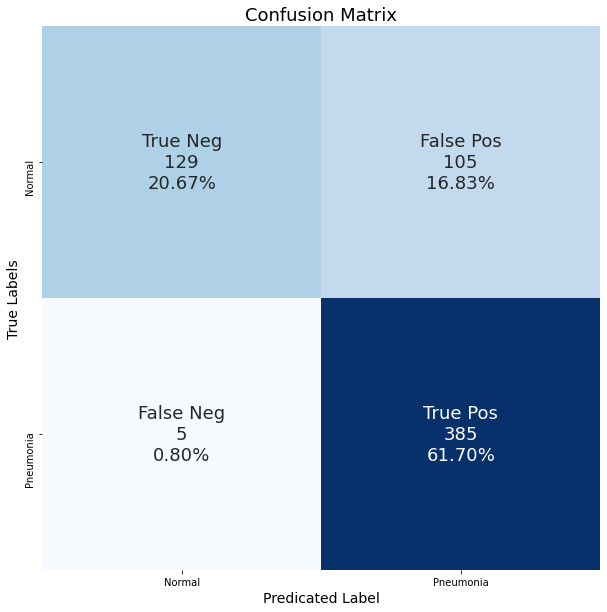

In [298]:
# plot confusion matrix using seaborn
import seaborn as sns

classification = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percents = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = ['Normal', 'Pneumonia']

inner_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(classification, counts, percents)]
inner_labels = np.asarray(inner_labels).reshape(2,2)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=inner_labels, annot_kws={"size": 18}, fmt='', xticklabels=labels, 
            yticklabels=labels, cbar=False, cmap="Blues")
plt.title('Confusion Matrix', size=18)
plt.ylabel('True Labels', size=14)
plt.xlabel('Predicated Label', size=14)
plt.show()

From above, we know that our accuracy score was 82.37% and our recall score was 98.72%. This is reflected in the confusion matrix above. We can see that our model was incorrectly classifying normal lungs as pneumonia lungs. While we would like our model to have as high accuracy as possible, false positives are preferred in this case. In the case of pneumonia, it is better to have healthy lungs and be classified as having pneumonia than to have pneumonia and being classified as having healthy lungs. Our results are satisfactory.

Next, we'll see what the characteristics of misclassified images were.

In [301]:
# get indices of all the classesifications so that we can view them using array_to_image to compare
true_p = []
false_p = []
false_n = []
true_n = []
for i in range(len(predictions)):
    if predictions[i] == y_test[i] and y_test[i]==0:
        true_n.append(i)
    if predictions[i] == y_test[i] and y_test[i]==1:
        true_p.append(i)
    if predictions[i] != y_test[i] and y_test[i]==0:
        false_p.append(i)
    if predictions[i] != y_test[i] and y_test[i]==1:
        false_n.append(i)

In [302]:
# verify the lengths are the same as the confusion matrix counts
len(true_n), len(false_p), len(false_n), len(true_p)

(129, 105, 5, 385)

**False Classifications**

''

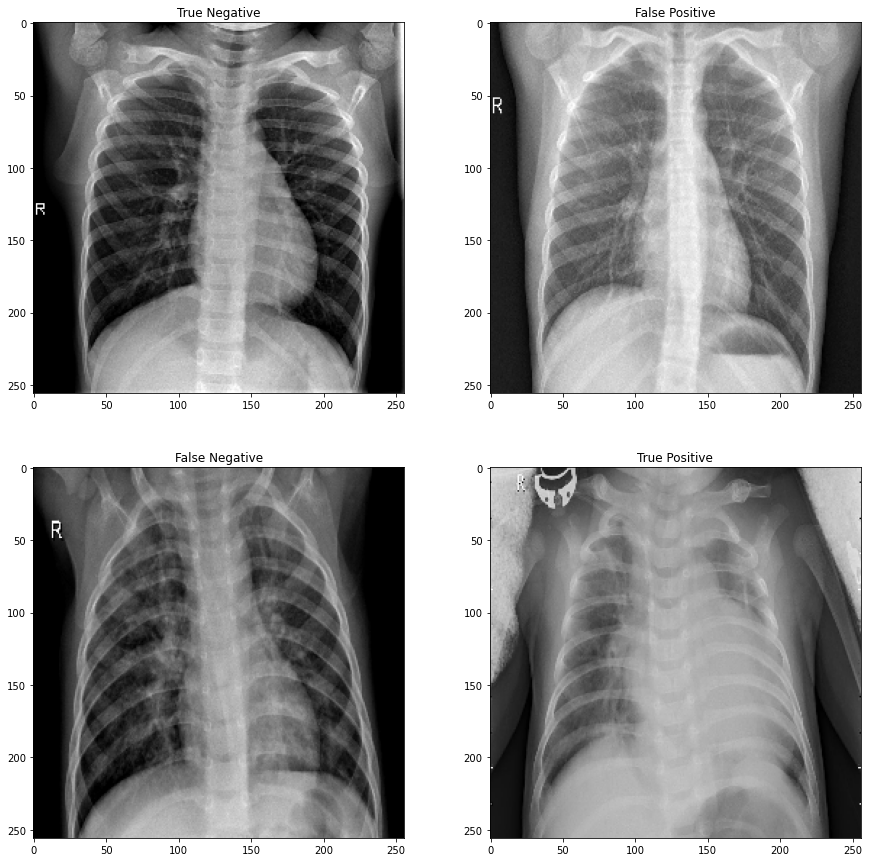

In [368]:
fig, ax = plt.subplots(nrows = 2, ncols=2,figsize=(15,15))
img1 = array_to_img(test_images[614])
ax[0, 0].imshow(img1)
ax[0, 0].set_title('True Negative');
img2 = array_to_img(test_images[554])
ax[0, 1].imshow(img2)
ax[0, 1].set_title('False Positive')
img3 = array_to_img(test_images[325])
ax[1, 0].imshow(img3)
ax[1, 0].set_title('False Negative')
img4 = array_to_img(test_images[618])
ax[1, 1].imshow(img4)
ax[1, 1].set_title('True Positive')
;

''

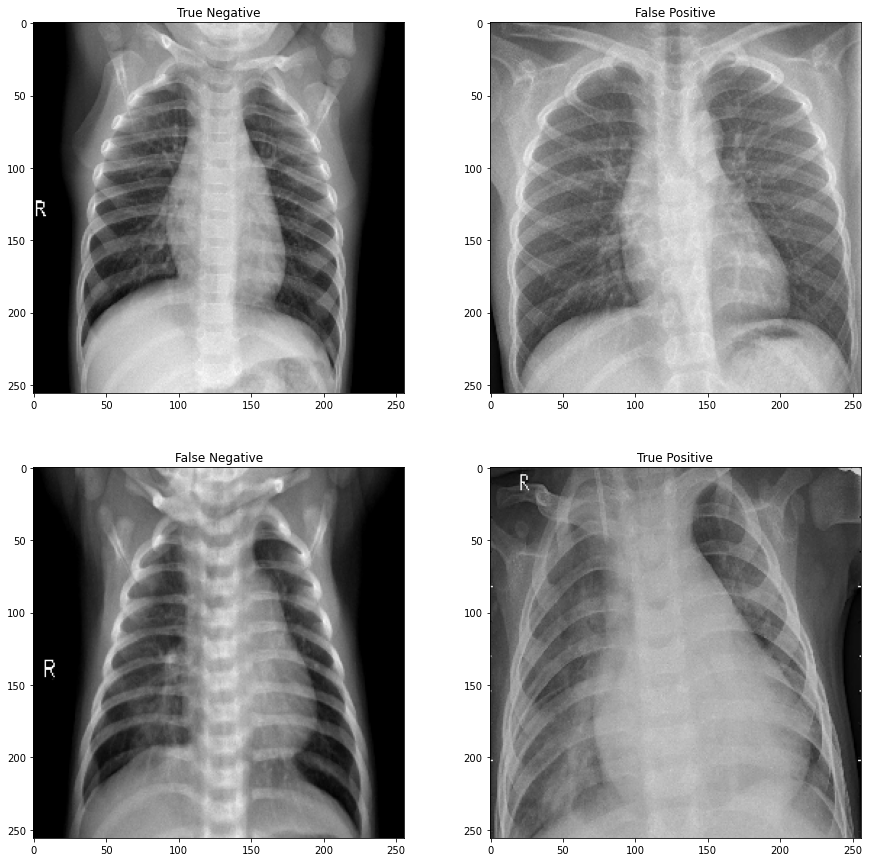

In [386]:
fig, ax = plt.subplots(nrows = 2, ncols=2,figsize=(15,15))
img1 = array_to_img(test_images[35])
ax[0, 0].imshow(img1)
ax[0, 0].set_title('True Negative');
img2 = array_to_img(test_images[19])
ax[0, 1].imshow(img2)
ax[0, 1].set_title('False Positive')
img3 = array_to_img(test_images[79])
ax[1, 0].imshow(img3)
ax[1, 0].set_title('False Negative')
img4 = array_to_img(test_images[23])
ax[1, 1].imshow(img4)
ax[1, 1].set_title('True Positive')
;

From above, we can see that there seems the be a pattern to the misclassifications. Generally speaking, lungs with pneumonia are more opaque that healthy lungs. We can see this by examining the amount of black that you can see through behind the chest. Generally, healthy lungs let show more black coloring. From the images pulled randomly we can see that some healthy lungs are little more opaque and hence are falsely classified as having pneumonia. Similarly, some pneumonia lungs show more black coloring and falsely classified as healthy. Our model seems to be basing its predictions on the opaqueness of the lungs and hasn't fully learned the intricacies of diagnosing pneumonia that a radiologist is more familiar with. This is a good start but the model requires more training to pick up on these intricacies. We can't fully automate the diagnosis process yet!